In [1]:
import biom
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as ss
from skbio.stats.composition import clr
from sklearn.metrics import balanced_accuracy_score, make_scorer, log_loss
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, cross_validate, RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression

from helper import tool_text_styling_dict, tool_palette

plt.style.use("./paper.mplstyle")

In [2]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

md = pd.read_table("../data/tcga_reanalyzed/processed/processed_md.tsv", sep="\t", index_col=0)
md["investigation"] = md["investigation"].str.replace("TCGA-", "")
investigations = [x for x in md["investigation"].value_counts().index if x != "BRCA"]
print(md.shape)
invest_labels = pd.Series(
    LabelEncoder().fit_transform(md["investigation"]),
    index=md.index
)
center_labels = pd.Series(
    LabelEncoder().fit_transform(md["data_submitting_center_label"]),
    index=md.index
)

(664, 38)


In [3]:
md["data_submitting_center_label"].value_counts()

Harvard Medical School                                274
Washington University School of Medicine              162
MD Anderson - Institute for Applied Cancer Science    111
Baylor College of Medicine                             65
Broad Institute of MIT and Harvard                     52
Name: data_submitting_center_label, dtype: int64

In [4]:
md.columns

Index(['sample_name', 'run_prefix', 'experimental_strategy', 'cgc_base_name',
       'filename', 'analyte_amount', 'analyte_A260A280Ratio',
       'aliquot_concentration', 'cgc_id', 'cgc_filename', 'vital_status',
       'gender', 'race', 'ethnicity', 'disease_type', 'data_subtype',
       'tcga_sample_id', 'cgc_case_uuid', 'sample_type', 'cgc_platform',
       'gdc_file_uuid', 'primary_site', 'age_at_diagnosis', 'cgc_sample_uuid',
       'cgc_aliquot_uuid', 'tcga_aliquot_id', 'reference_genome',
       'tcga_case_id', 'investigation', 'days_to_death',
       'data_submitting_center_label', 'tissue_source_site_label',
       'country_of_sample_procurement', 'portion_is_ffpe',
       'pathologic_t_label', 'pathologic_n_label',
       'histological_diagnosis_label', 'pathologic_stage_label'],
      dtype='object')

In [5]:
centers_short_map = {
    "Washington University School of Medicine": "WUSTL",
    "Broad Institute of MIT and Harvard": "BI",
    "Baylor College of Medicine": "BCM",
    "Harvard Medical School": "HMS",
    "MD Anderson - Institute for Applied Cancer Science": "MDA"
}

In [6]:
tbl = biom.load_table("../data/tcga_reanalyzed/processed/merged_tbl.biom")

In [7]:
tbl.shape

(964, 664)

In [8]:
centers = md["data_submitting_center_label"].unique()

center_pal = dict(zip(
    centers,
    sns.color_palette("colorblind", len(centers))
))

/home/grahman/miniconda3/envs/birdman-analyses-final/lib/python3.8/site-packages/gemelli/preprocessing.py:418: RuntimeWarning: divide by zero encountered in log
  mat = np.log(matrix_closure(mat))
/home/grahman/miniconda3/envs/birdman-analyses-final/lib/python3.8/site-packages/gemelli/preprocessing.py:418: RuntimeWarning: divide by zero encountered in log
  mat = np.log(matrix_closure(mat))
/home/grahman/miniconda3/envs/birdman-analyses-final/lib/python3.8/site-packages/gemelli/preprocessing.py:418: RuntimeWarning: divide by zero encountered in log
  mat = np.log(matrix_closure(mat))


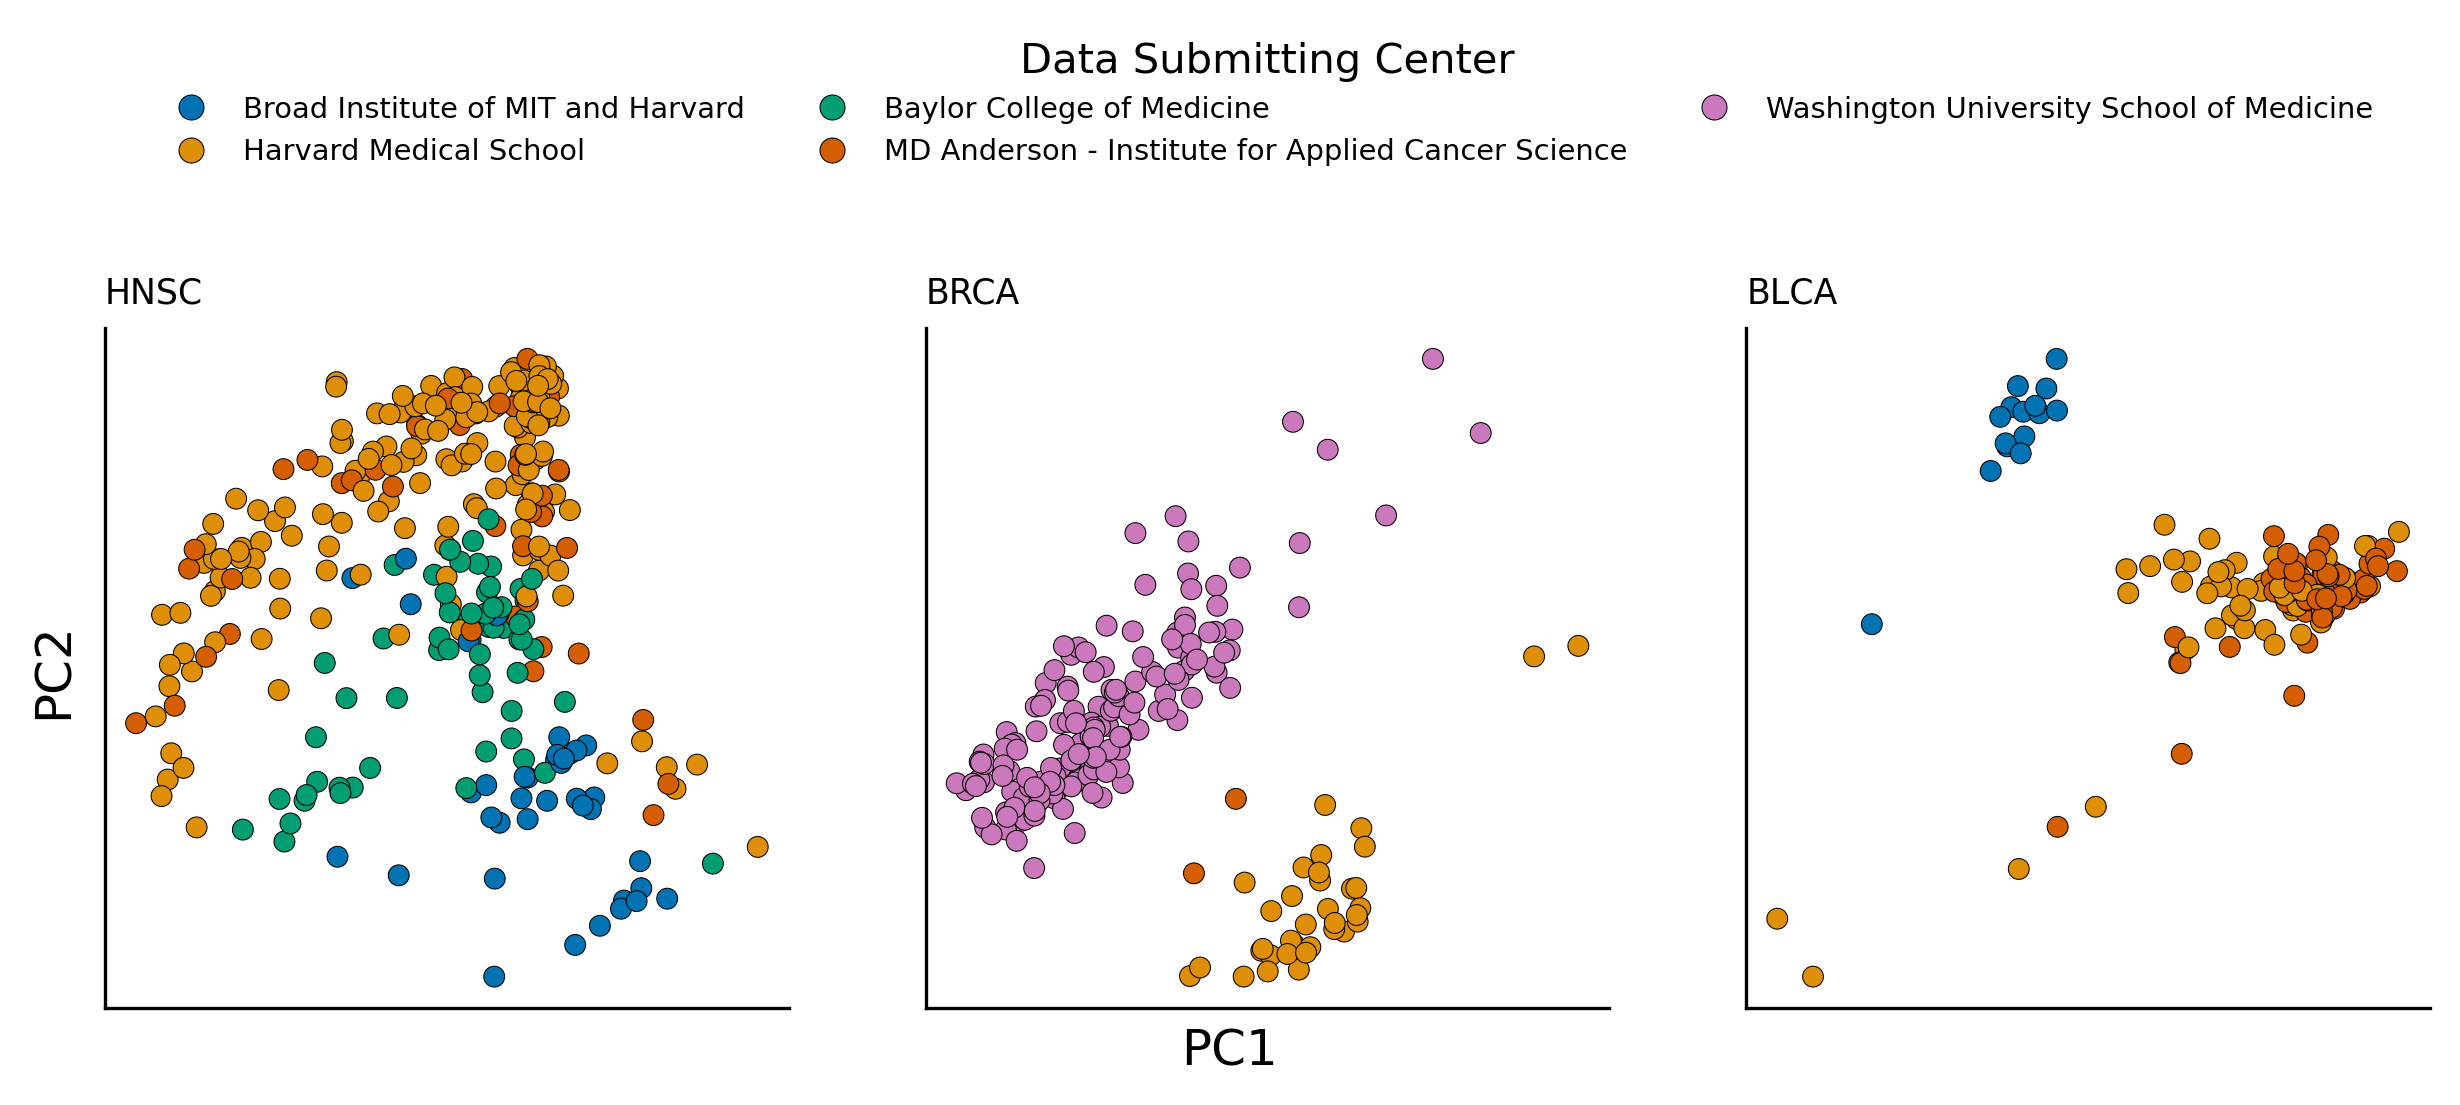

In [9]:
from gemelli.rpca import rpca

fig = plt.figure(figsize=(10, 3))
axs = []

for i, invest in enumerate(md["investigation"].value_counts().index, start=1):
    idx = md[md["investigation"] == invest].index
    tbl_filt = tbl.filter(idx, inplace=False)
    tbl_filt.remove_empty()
    
    ord_res, dm = rpca(tbl_filt)
    samp_axes = ord_res.samples.join(md, how="inner")
    
    ax = fig.add_subplot(1, 3, i)
    sns.scatterplot(
        data=samp_axes,
        x="PC1",
        y="PC2",
        hue="data_submitting_center_label",
        palette=center_pal,
        legend=False,
        linewidth=0.25,
        edgecolor="black",
        s=25,
        ax=ax
    )

    ax.set_title(invest, fontsize="small")
    ax.yaxis.set_visible(False)
    ax.xaxis.set_visible(False)
    axs.append(ax)
    
from matplotlib.lines import Line2D

handles = []
for center, color in center_pal.items():
    handle = Line2D([0], [0], color=color, label=center, marker="o",
                    lw=0, mew=0.25, mec="black")
    handles.append(handle)
    
axs[1].legend(
    handles=handles,
    ncol=3,
    loc="lower center",
    bbox_to_anchor=[0.5, 1.2],
    frameon=False,
    title="Data Submitting Center"
)

fig.supylabel("PC2", x=0.10)
fig.supxlabel("PC1", y=0.05)
    
plt.savefig("../figures/tcga/cancer_type_rpca.pdf")
plt.savefig("../figures/tcga/cancer_type_rpca.png")

plt.show()

In [10]:
full_ord_res, full_dm = rpca(tbl, n_components=5)
full_samples = full_ord_res.samples.join(md)

/home/grahman/miniconda3/envs/birdman-analyses-final/lib/python3.8/site-packages/gemelli/preprocessing.py:418: RuntimeWarning: divide by zero encountered in log
  mat = np.log(matrix_closure(mat))


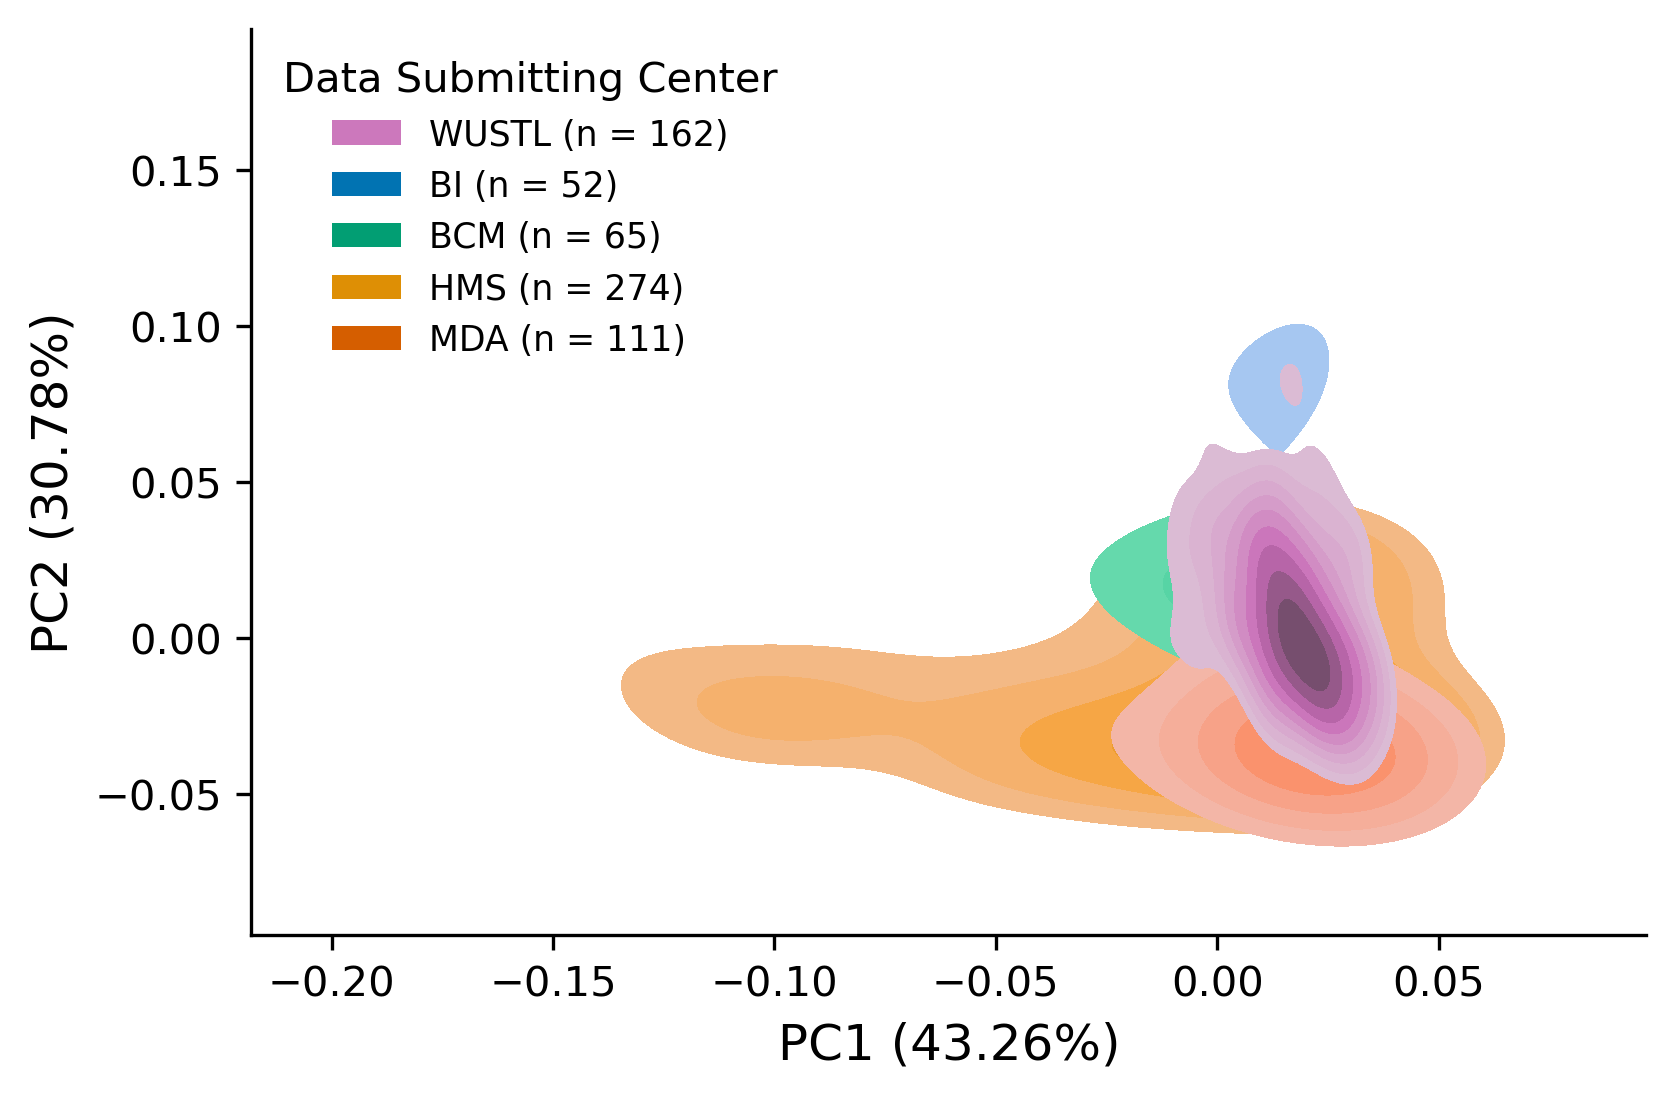

In [11]:
fig, ax = plt.subplots(1, 1)

sns.kdeplot(
    data=full_samples,
    x="PC1",
    y="PC2",
    hue="data_submitting_center_label",
    fill=True,
    palette=center_pal,
    thresh=0.2,
    legend=False,
    ax=ax
)

#ax.set_ylim([-0.06, 0.09])

from matplotlib.patches import Patch

handles = []
for center, center_short in centers_short_map.items():
    n = len(md[md["data_submitting_center_label"] == center])
    p = Patch(
        facecolor=center_pal[center],
        label=f"{center_short} (n = {n})"
    )
    handles.append(p)
    
ax.legend(
    handles=handles,
    loc="upper left",
    title="Data Submitting Center",
    fontsize="small",
    frameon=False
)

prop_exp = full_ord_res.proportion_explained * 100
ax.set_xlabel(f"PC1 ({prop_exp[0]:.2f}%)")
ax.set_ylabel(f"PC2 ({prop_exp[1]:.2f}%)")

plt.savefig("../figures/tcga_reanalyzed/full_rpca_center.pdf")
plt.savefig("../figures/tcga_reanalyzed/full_rpca_center.png")

plt.show()

In [12]:
import re

invest_reg = re.compile("\[T.TCGA-(\w+)\]_(mean|std)")

In [13]:
quantiles = pd.read_table("../results/tcga_reanalyzed/feature_quantiles.tsv", sep="\t")
#quantiles = quantiles.set_index(["feature", "quantile"])
quantiles.head()

,quantile,BLCA,HNSC,feature
0,0.025,-7.463171,-5.336154,Actinopolymorpha
1,0.975,1.546886,2.681329,Actinopolymorpha
2,0.025,-6.964280,-4.406135,Methylophilus
3,0.975,1.551006,3.147211,Methylophilus
4,0.025,-8.519266,-3.526909,Sinorhizobium


In [14]:
quantiles.shape

(1928, 4)

In [16]:
tbl_df = tbl.to_dataframe(dense=True).T
table_clr = pd.DataFrame(clr(tbl_df.values + 1), index=tbl_df.index, columns=tbl_df.columns)

In [17]:
ancombc_res = pd.read_table("../results/tcga_reanalyzed/ancombc_results_beta.tsv", sep="\t", index_col=0)
ancombc_res = ancombc_res.filter(like="investigation")
ancombc_res.columns = [x.replace("investigation", "") for x in ancombc_res.columns]
print(ancombc_res.shape)
ancombc_res.head()

(964, 2)


,BLCA,HNSC
Abiotrophia,0.239495,0.537977
Acetoanaerobium,0.090555,0.093013
Acetobacter,-0.125111,0.035932
Acetobacterium,0.026719,0.024262
Acholeplasma,0.079456,0.168108


In [18]:
aldex2_regex = re.compile("model\.investigation([A-Z]+) Estimate")

aldex2_res = pd.read_table("../results/tcga_reanalyzed/aldex2_results.tsv", sep="\t", index_col=0)
cols = [x for x in aldex2_res.columns if "investigation" in x]
aldex2_res = aldex2_res[cols]
aldex2_res = aldex2_res.filter(like="Estimate")
aldex2_res = aldex2_res.rename(columns=lambda x: aldex2_regex.search(x).groups()[0])

print(aldex2_res.shape)
aldex2_res.head()

(964, 2)


,BLCA,HNSC
Abiotrophia,1.047179,1.450290
Acetoanaerobium,0.467191,0.148215
Acetobacter,-0.034766,0.070733
Acetobacterium,0.513547,0.116645
Acholeplasma,0.686108,0.544607


In [19]:
import pathlib

deseq2_path = pathlib.Path("../results/tcga_reanalyzed/deseq2/")
deseq2_invest_files = deseq2_path.glob("*.tsv")
deseq2_dfs = []

for f in deseq2_invest_files:
    invest = f.stem
    if invest == "Intercept":
        continue
    _df = pd.read_table(f, sep="\t", index_col=0)
    _df = _df["log2FoldChange"]
    _df.name = invest
    deseq2_dfs.append(_df)

deseq2_res = pd.concat(deseq2_dfs, axis=1)

print(deseq2_res.shape)
deseq2_res.head()

(964, 2)


,HNSC,BLCA
Abiotrophia,3.858699,1.785072
Acetoanaerobium,1.039245,0.951195
Acetobacter,0.264230,-0.303836
Acetobacterium,0.293656,0.373648
Acholeplasma,1.013286,0.635993


In [20]:
songbird_regex = re.compile("\[T.TCGA-(\w+)\]")

songbird_res = pd.read_table("../results/tcga_reanalyzed/songbird/differentials.tsv", index_col=0)
songbird_res = songbird_res.filter(like="investigation")
songbird_res.columns = [
    songbird_regex.search(x).groups()[0] for x in songbird_res.columns
    if "investigation" in x
]
    
print(songbird_res.shape)
songbird_res.head()

(964, 2)


,BLCA,HNSC
featureid,,
Abiotrophia,0.264831,0.473194
Acetoanaerobium,0.893416,-0.401383
Acetobacter,-0.004311,0.711860
Acetobacterium,0.755494,0.058209
Acholeplasma,1.084264,0.601138


In [21]:
def log_ratio(table, top_feats, bot_feats):
    num_sum = table.loc[:, top_feats].sum(axis=1)
    denom_sum = table.loc[:, bot_feats].sum(axis=1)
    lr_df = pd.concat([num_sum, denom_sum], axis=1)
    lr_df.columns = ["num", "denom"]
    #lr_df = lr_df.dropna(how="all")
    lr_df = lr_df + 1
    lr_df["log_ratio"] = np.log(lr_df["num"]/lr_df["denom"]).to_frame()
    return lr_df

In [22]:
from evident.stats import calculate_cohens_d

def get_predictor_df(results_df, n=50, is_birdman=False):
    predictors = []
    lr_df_dict = dict()

    for invest in investigations:
        if not is_birdman:
            col = results_df[invest].sort_values(ascending=False)
            top_n = col.head(n).index
            bot_n = col.tail(n).index
        else:
            top_n = results_df.query("quantile == 0.975").sort_values(by=invest)["feature"].tail(n).values
            bot_n = results_df.query("quantile == 0.025").sort_values(by=invest)["feature"].head(n).values
            
        lr = log_ratio(tbl_df, top_n, bot_n)["log_ratio"]
        lr.name = invest

        _df = md[["investigation"]].assign(log_ratio=lr)
        lr_df_dict[invest] = lr
        _x = _df.query("investigation != @invest")["log_ratio"]
        _y = _df.query("investigation == @invest")["log_ratio"]   
        predictors.append(lr)

    return pd.concat(predictors, axis=1).join(md[["investigation", "data_submitting_center_label"]]), lr_df_dict

In [23]:
num_feats = 100

tool_predictor_dfs = dict()
tool_lr_df_dicts = dict()

res_dfs = {
    "birdman": quantiles,
    "aldex2": aldex2_res,
    "ancombc": ancombc_res,
    "deseq2": deseq2_res,
    "songbird": songbird_res
}

for tool, _df in res_dfs.items():
    print(tool)
    is_birdman = tool == "birdman"
    predictor_df, lr_df_dict = get_predictor_df(_df, num_feats, is_birdman)
    tool_predictor_dfs[tool] = predictor_df
    tool_lr_df_dicts[tool] = lr_df_dict

birdman
aldex2
ancombc
deseq2
songbird


In [24]:
predictor_df

,HNSC,BLCA,investigation,data_submitting_center_label
s15482,3.594767,-2.836605,HNSC,Broad Institute of MIT and Harvard
s15483,-2.035853,-3.480430,HNSC,Broad Institute of MIT and Harvard
s15484,-0.864399,-2.441802,HNSC,Broad Institute of MIT and Harvard
s15485,-2.222023,-4.324669,HNSC,Broad Institute of MIT and Harvard
s15487,1.884874,7.254481,HNSC,Harvard Medical School
...,...,...,...,...
s6915,1.280346,2.888982,BRCA,Washington University School of Medicine
s6916,1.057127,4.804698,BRCA,MD Anderson - Institute for Applied Cancer Sci...
s6917,-3.674083,3.763063,BRCA,Harvard Medical School
s6918,-2.892085,3.668697,BRCA,Harvard Medical School


In [25]:
from evident.stats import calculate_cohens_d

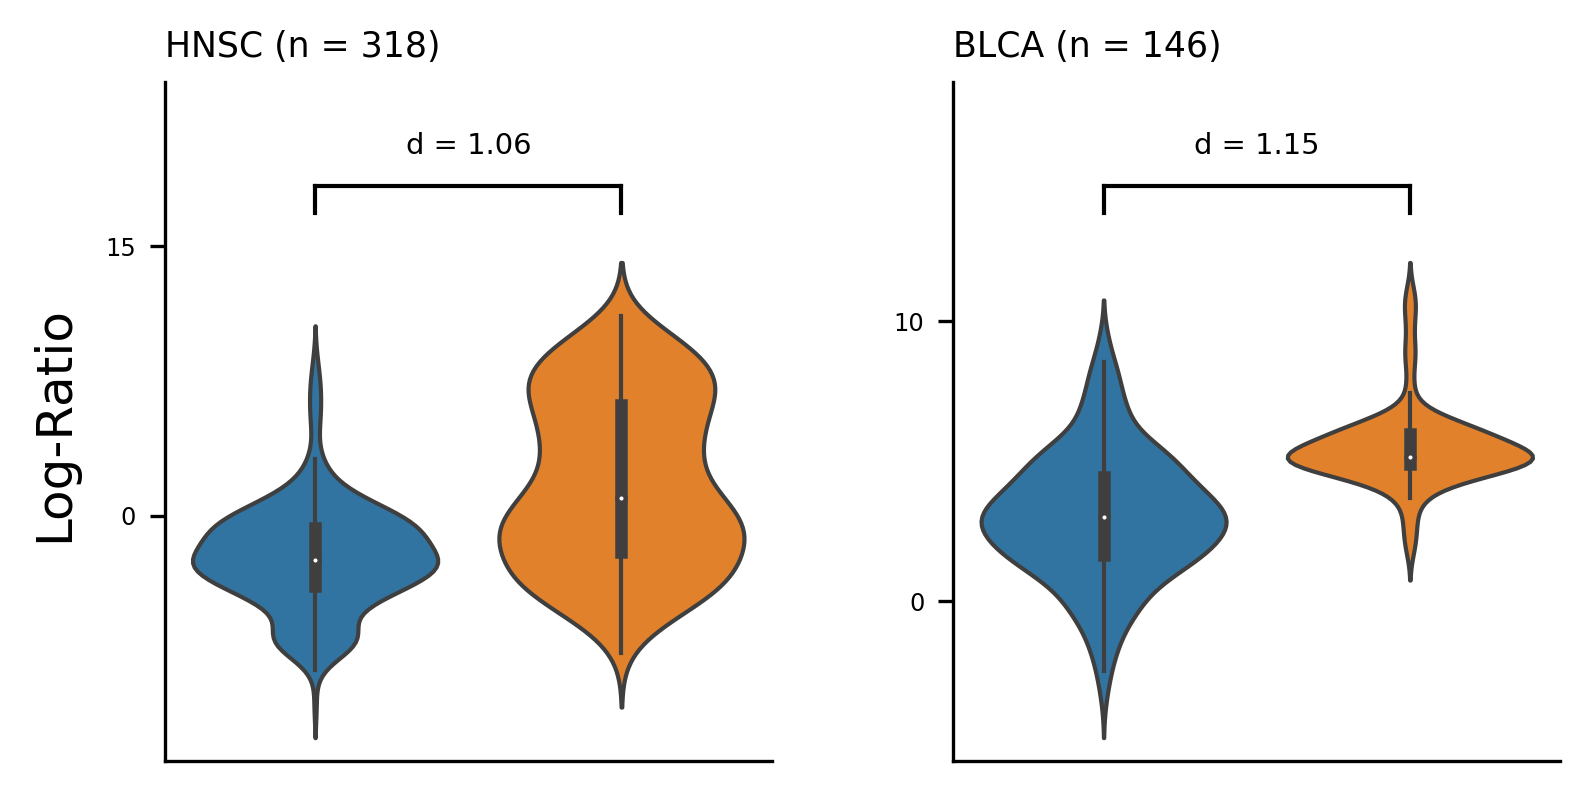

In [26]:
from matplotlib import ticker
fig = plt.figure(figsize=(6, 3))

for i, (invest, _lr) in enumerate(tool_lr_df_dicts["birdman"].items(), start=1):
    ax = fig.add_subplot(1, 2, i)
    _df = pd.concat([_lr, md[["investigation", "data_submitting_center_label"]]], axis=1)
    _df["is_invest"] = _df["investigation"] == invest
    sns.violinplot(
        data=_df,
        x="is_invest",
        y=invest,
        linewidth=1,
        scale="width",
        ax=ax
    )
    ax.xaxis.set_visible(False)
    ax.set_ylabel("")
    ax.tick_params("y", labelsize="xx-small")
    ymin, ymax = ax.get_ylim()
    yrange = ymax - ymin
    ax.set_ylim([ymin, ymax+yrange*0.3])
    
    bot_loc = ymax+yrange*0.05
    top_loc = ymax+yrange*0.1
    ax.plot([0, 1], [top_loc, top_loc], color="k", lw=1)
    ax.plot([0, 0], [bot_loc, top_loc], color="k", lw=1)
    ax.plot([1, 1], [bot_loc, top_loc], color="k", lw=1)
    
    _x = _df.query("is_invest == True")[invest]
    _y = _df.query("is_invest == False")[invest]
    d = calculate_cohens_d(_x, _y)
    ax.text(
        x=0.5,
        y=ymax+yrange*0.15,
        s=f"d = {d:.2f}",
        va="bottom",
        ha="center",
        fontsize="x-small"
    )
    
    ax.yaxis.set_major_locator(ticker.MaxNLocator(3))
    ax.set_title(f"{invest} (n = {len(_x)})", fontsize="small")

plt.subplots_adjust(wspace=0.3, hspace=0.25)
fig.supylabel("Log-Ratio", x=0.05)

plt.show()

In [27]:
model = LogisticRegression(
    multi_class="multinomial",
    solver="lbfgs",
    max_iter=5000,
    class_weight="balanced",
    fit_intercept=True,
    C=1
)

In [28]:
from sklearn.model_selection import StratifiedKFold

new_cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=5, random_state=1)

scorer = make_scorer(balanced_accuracy_score, adjusted=False)
scoring = {"balanced_accuracy": scorer, "f1_weighted": "f1_weighted"}

In [29]:
md.groupby(["data_submitting_center_label", "investigation"]).size()

data_submitting_center_label                        investigation
Baylor College of Medicine                          HNSC              65
Broad Institute of MIT and Harvard                  BLCA              15
                                                    HNSC              37
Harvard Medical School                              BLCA              63
                                                    BRCA              36
                                                    HNSC             175
MD Anderson - Institute for Applied Cancer Science  BLCA              68
                                                    BRCA               2
                                                    HNSC              41
Washington University School of Medicine            BRCA             162
dtype: int64

In [30]:
centers = [
    "Broad Institute of MIT and Harvard",
    "Harvard Medical School",
    "MD Anderson - Institute for Applied Cancer Science"
]

## Tool Log-Ratios

In [31]:
from collections import defaultdict

tool_perf_dict = defaultdict(dict)

for tool, predictor_df in tool_predictor_dfs.items():
    print(tool)
    predictor_df = predictor_df.copy()
    predictor_df = predictor_df[predictor_df["data_submitting_center_label"].isin(centers)]
        
    print("-------------")
    for center, _df in predictor_df.groupby("data_submitting_center_label"):
        if center == "MD Anderson - Institute for Applied Cancer Science":
            _df = _df[_df["investigation"].isin(["BLCA", "HNSC"])]
        print(center)

        try:
            X = _df[investigations]
            _invests = _df["investigation"].unique()
            _invests = [x for x in _invests if x != "BRCA"]
            X = X[_invests]

            y = LabelEncoder().fit_transform(_df["investigation"])
            scores = cross_validate(model, X, y, scoring=scoring, cv=new_cv, n_jobs=-1)
            tool_perf_dict[tool][center] = scores
        except Exception:
            print("Skipping..")
        
        print(scores["test_balanced_accuracy"].mean(), scores["test_f1_weighted"].mean())
        print("====================================")
    print()

birdman
-------------
Broad Institute of MIT and Harvard
0.9251709401709401 0.9277353940303642
Harvard Medical School
0.9081919357781426 0.869158178284727
MD Anderson - Institute for Applied Cancer Science
0.8909467344249953 0.9003989616803082

aldex2
-------------
Broad Institute of MIT and Harvard
0.7217521367521368 0.750294671919356
Harvard Medical School
0.8283954740412951 0.7985412200695631
MD Anderson - Institute for Applied Cancer Science
0.7644116752812405 0.7618919880751845

ancombc
-------------
Broad Institute of MIT and Harvard
0.5876495726495726 0.6366398949635167
Harvard Medical School
0.7587873671450527 0.6727581597942874
MD Anderson - Institute for Applied Cancer Science
0.7308966395922918 0.7358188702027605

deseq2
-------------
Broad Institute of MIT and Harvard
0.6326495726495727 0.6010830301641337
Harvard Medical School
0.8857823173428083 0.8554577833993668
MD Anderson - Institute for Applied Cancer Science
0.7039243365330321 0.7171580969208361

songbird
-----------

## CLR Random Forest

In [32]:
rf_model = RandomForestClassifier(random_state=63, n_estimators=100)
rf_scores = dict()

for center, _df in md.groupby("data_submitting_center_label"):
    if center not in centers:
        continue
    if center == "MD Anderson - Institute for Applied Cancer Science":
        _df = _df[_df["investigation"].isin(["BLCA", "HNSC"])]
    idx = _df.index
    
    # Remove feats with all zeros before performing CLR
    X = tbl_df.loc[idx]
    non_zero = tbl_df.loc[idx].any()
    ids_to_keep = non_zero[non_zero].index
    X = X.loc[:, ids_to_keep]
    X = pd.DataFrame(clr(X.values + 1), index=X.index, columns=X.columns)
    
    y = LabelEncoder().fit_transform(_df.loc[idx]["investigation"])
    scores = cross_validate(rf_model, X, y, scoring=scoring, cv=new_cv, n_jobs=-1)
    rf_scores[center] = scores
    print(center)
    print(X.shape)
    print(len(np.unique(y)))
    print(scores["test_balanced_accuracy"].mean(), scores["test_f1_weighted"].mean())
    print("=======================")

Broad Institute of MIT and Harvard
(52, 846)
2
0.8326068376068376 0.8581310096868493
Harvard Medical School
(274, 961)
3
0.7933397035676405 0.8196182639691912
MD Anderson - Institute for Applied Cancer Science
(109, 932)
2
0.8949716949716949 0.8974602179558686


In [33]:
invest_count_per_center = dict(
    md
    .groupby(["data_submitting_center_label"])
    .apply(lambda x: len(x["investigation"].unique()))
)

In [34]:
from helper import tool_palette, tool_text_styling_dict

tool_acc_dfs = []

for tool, perf_dict in tool_perf_dict.items():
    _df = pd.DataFrame.from_dict(perf_dict)
    _df =  (
        _df
        .apply(pd.Series.explode)
        .reset_index()
        .rename(columns={"index": "metric"})
        .melt(id_vars=["metric"], var_name="center")
        .assign(model=tool_text_styling_dict[tool])
        .query("metric == ['test_balanced_accuracy', 'test_f1_weighted']")
    )
    tool_acc_dfs.append(_df)
    
rf_score_df = pd.DataFrame.from_dict(rf_scores)
rf_score_df = (
    rf_score_df
    .apply(pd.Series.explode)
    .reset_index()
    .rename(columns={"index": "metric"})
    .melt(id_vars=["metric"], var_name="center")
    .assign(model="Random Forest")
    .query("metric == ['test_balanced_accuracy', 'test_f1_weighted']")
)

all_perf_df = pd.concat(tool_acc_dfs + [rf_score_df]).reset_index(drop=True)

all_perf_df["metric"] = all_perf_df["metric"].replace({
    "test_f1_weighted": "Classifier F1 Score",
    "test_balanced_accuracy": "Classifier Accuracy"
})

def add_num_cancer_types(row):
    invest_count = invest_count_per_center[row["center"]]
    return f"{row['center_short']}\n({invest_count} Cancer Types)"

def add_num_samples(center):
    return md.query("data_submitting_center_label == @center").shape[0]

all_perf_df["N"] = all_perf_df["center"].map(add_num_samples)
all_perf_df["center_short"] = all_perf_df["center"].map(centers_short_map)
all_perf_df["center_short"] = all_perf_df.apply(add_num_cancer_types, axis=1)

all_perf_df.head()

,metric,center,value,model,N,center_short
0,Classifier Accuracy,Broad Institute of MIT and Harvard,0.923077,BIRDMAn,52,BI\n(2 Cancer Types)
1,Classifier Accuracy,Broad Institute of MIT and Harvard,0.9,BIRDMAn,52,BI\n(2 Cancer Types)
2,Classifier Accuracy,Broad Institute of MIT and Harvard,1,BIRDMAn,52,BI\n(2 Cancer Types)
3,Classifier Accuracy,Broad Institute of MIT and Harvard,0.923077,BIRDMAn,52,BI\n(2 Cancer Types)
4,Classifier Accuracy,Broad Institute of MIT and Harvard,0.9,BIRDMAn,52,BI\n(2 Cancer Types)


In [35]:
tool_palette["Random Forest"] = "lightgray"
order = ["BIRDMAn", "DESeq2", "ALDEx2", "ANCOM-BC", "Songbird", "Random Forest"]

In [36]:
perf_mat = (
    all_perf_df
    .query("metric == 'Classifier Accuracy'")
    .groupby(["center_short", "model"])["value"]
    .apply(lambda x: x.mean())
    .reset_index()
    .pivot(index="center_short", columns="model", values="value")
    .loc[:, order]
)
perf_mat

model,BIRDMAn,DESeq2,ALDEx2,ANCOM-BC,Songbird,Random Forest
center_short,,,,,,
BI\n(2 Cancer Types),0.925171,0.632650,0.721752,0.587650,0.959402,0.832607
HMS\n(3 Cancer Types),0.908192,0.885782,0.828395,0.758787,0.867416,0.793340
MDA\n(3 Cancer Types),0.890947,0.703924,0.764412,0.730897,0.874205,0.894972


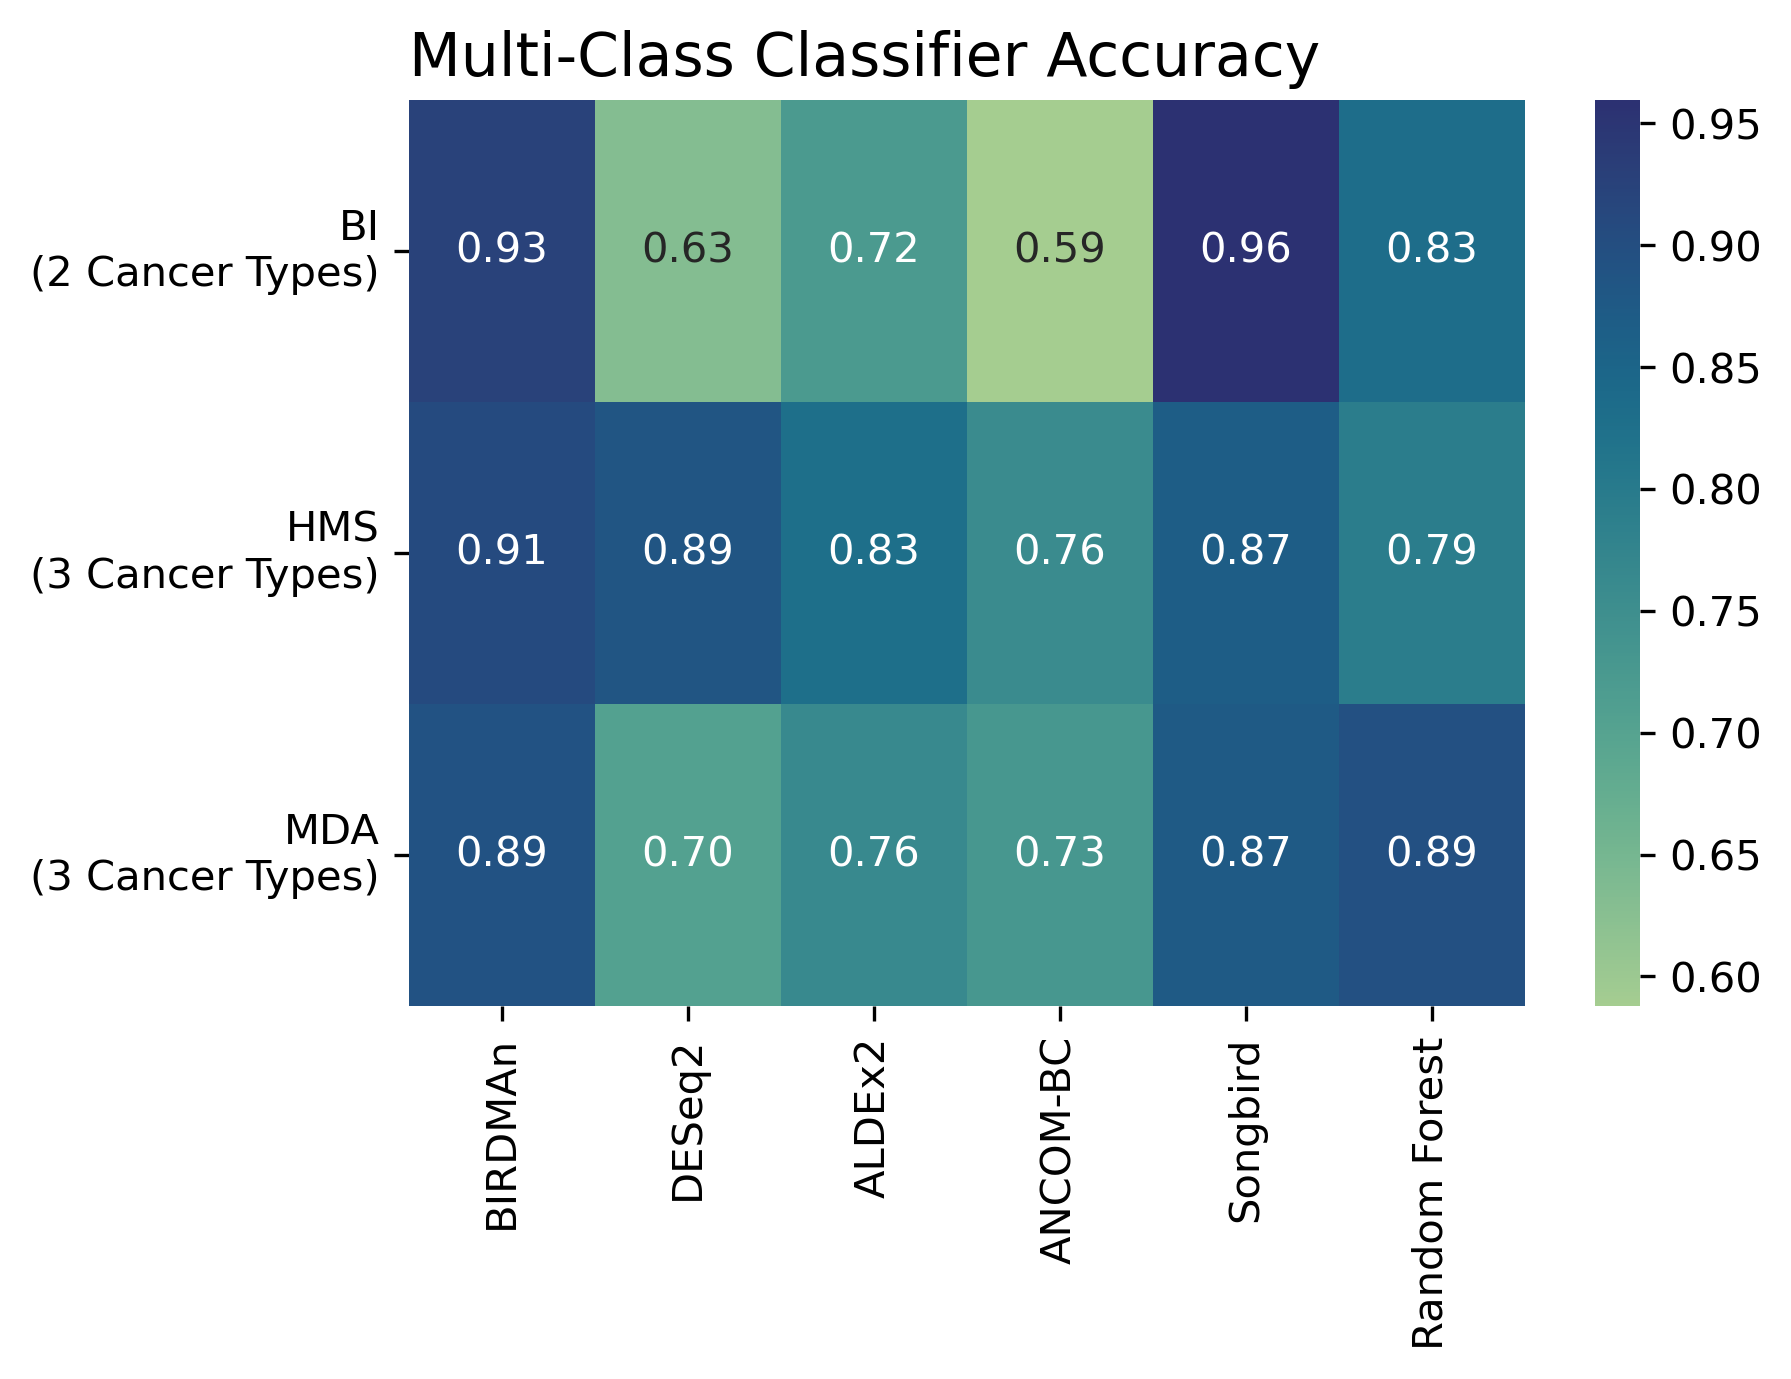

In [37]:
fig, ax = plt.subplots(1, 1)

sns.heatmap(perf_mat, annot=True, cmap="crest", ax=ax, fmt=".2f")
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_title("Multi-Class Classifier Accuracy")

plt.savefig("../figures/tcga_reanalyzed/per_center_classifier_perf.pdf")
plt.savefig("../figures/tcga_reanalyzed/per_center_classifier_perf.png")

plt.show()